<a href="https://colab.research.google.com/github/AnishaChawla/Image_Classification_CNN/blob/main/nn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import cv2
import os
import random
from PIL import Image

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import time

import pdb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# image augmentation
random.seed(41)
#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomPerspective(distortion_scale=0.4),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
data_path = "/content/drive/My Drive/VIP_2022_fall_classification"
testing_data_path = "/content/drive/My Drive/VIP_2022_fall_classification/Test (dont use it to train your model)"

# categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

train_data = datasets.ImageFolder(data_path + '/Train', transform= train_transforms)
test_data = datasets.ImageFolder(data_path + '/Test (dont use it to train your model)', transform= test_transforms)


# Split the training set into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Define the dataloaders for each dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

train_data_size = len(train_data)
test_data_size = len(test_data)
train_data_indices = list(range(train_data_size))

#val_split_index = int(np.floor(0.8 * train_data_size))
val_split_index = int(np.floor(0.3 * train_data_size))

train_idx, val_idx = train_data_indices[:val_split_index], train_data_indices[val_split_index:]

# train_data = datasets.ImageFolder(data_path + '/Train', transform= train_transforms, subset_indices=list(range(0, val_split_index)))

train_data_split = torch.utils.data.Subset(train_data, indices=list(range(0, val_split_index)))
val_data_split = torch.utils.data.Subset(train_data, indices=list(range(val_split_index, train_data_size)))

train_data_split_size = len(train_data_split)
val_data_split_size = len(val_data_split)

valid_data_size = len(val_data_split)

classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))
# print(classes)


In [ ]:
batch_size = 32

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(weights=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Changing the Classifier
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(classes)),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)


# Moving the model to device
resnet50.to(device)

#defining the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=6, gamma=0.35)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.0MB/s]


In [ ]:
learning_rate = 1e-4

num_ep = 1
steps = 0

loss_history = []

# Loss and Accuracy within the epoch
train_loss = 0.0
train_acc = 0.0
valid_loss = 0.0
valid_acc = 0.0

val_acc_list = []

for e in range(num_ep):

  train_loss = 0
  resnet50.train()
  #train the model
  for i, (images, labels) in enumerate(train_dataloader):
    steps+=1
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    # Forward Pass
    logits = resnet50(images)
    loss = loss_fn(logits,labels)
    loss_history.append(loss.item())
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item() * images.size(0)
    # Compute the accuracy
    ret, predictions = torch.max(logits.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    train_acc += acc.item() * images.size(0)
    print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
    # torch.save()
    # save the model state and optimizer state
    torch.save({
            'model_state_dict': resnet50.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': num_ep,
            'loss': loss
            }, 'model_checkpoint.pt')

scheduler.step()

# Plot your training loss
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.show()

# Find the MSE loss for last epoch
mse = mse = loss_history[-1]

# See how the model fits on training dataset and plot the
y_hat = resnet50(images).cpu().detach().numpy()
plt.figure(figsize=(12,7))
plt.title('Pytorch Model')
# plt.scatter(images, labels, label='Data $(x, y)$')
# plt.scatter(images, labels, label='Data $(x, y)$')
print(images.cpu().numpy().flatten().shape)
print(labels.cpu().numpy().flatten().shape)


resnet50.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_dataloader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet50(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_dataloader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))



import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = resnet50(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matpririx(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()


from sklearn.metrics import precision_recall_curve
# !pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch

y_pred = []
y_true = []
pred = torch.tensor(y_pred)
true = torch.tensor(y_true)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)



Test Loss: 0.597100

Test Accuracy of     0: 67.73% (1480/2185)
Test Accuracy of     1: 98.31% (2330/2370)
Test Accuracy of     2: 86.80% (2400/2765)
Test Accuracy of     3: 51.62% (1355/2625)
Test Accuracy of     4: 93.14% (2375/2550)
Test Accuracy of     5: 95.01% (2380/2505)

Test Accuracy (Overall): 82.13% (12320/15000)
6
forest


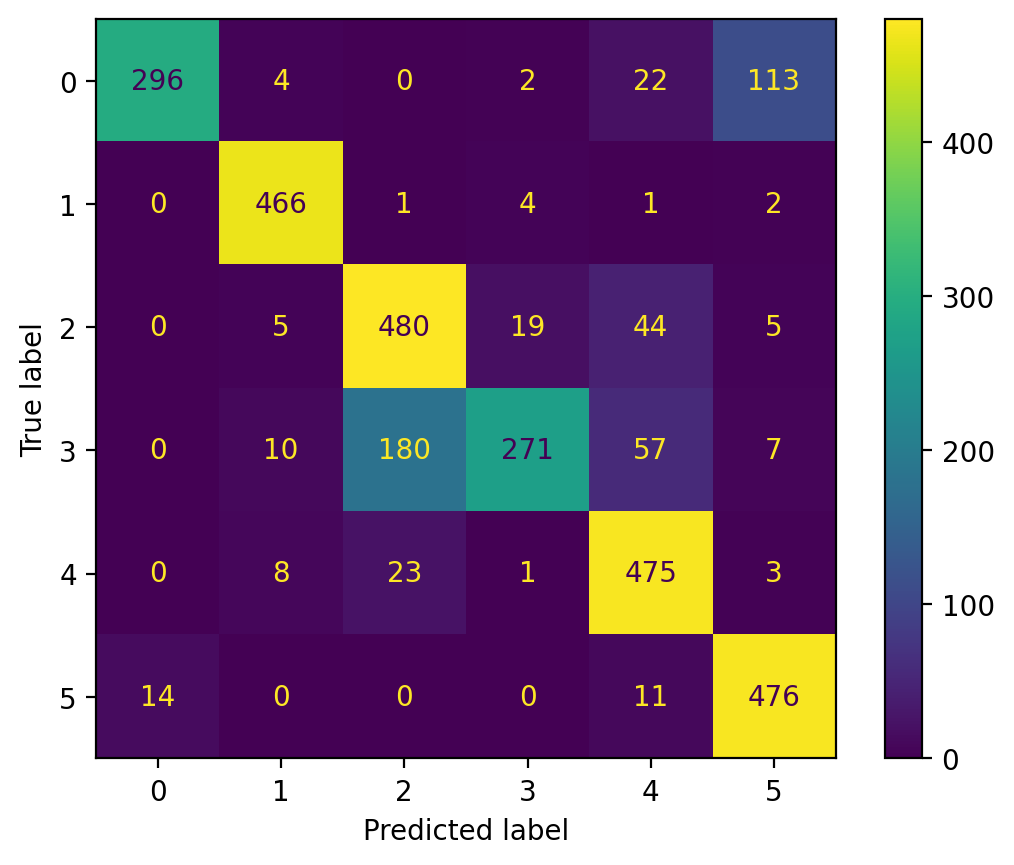

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


tensor(0.)


In [ ]:

# /////////////............../////////////............../////////////............../////////////..............



resnet50.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_dataloader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet50(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_dataloader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))



# //////////////............../////////////............../////////////............../////////////..............


import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = resnet50(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matpririx(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()

# plt.figure(figsize = (12,7))
# # sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# /////////////............../////////////............../////////////..............


from sklearn.metrics import precision_recall_curve
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch

y_pred = []
y_true = []
pred = torch.tensor(y_pred)
true = torch.tensor(y_true)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)

# metric = MulticlassPrecisionRecallCurve(num_classes=6)
# metric.update(pred, classes)
# metric.compute()

# # Plot the curve
# plt.plot(recall, precision)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()




In [ ]:

# Validation
history = []

with torch.no_grad():
    # Set to evaluation mode
    resnet50.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    # Validation loop
    for j, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass - compute outputs on input data using the model
        outputs = resnet50(images)
        loss = loss_fn(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        print(images.size(0))
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        val_acc_list.append(acc.item())
        valid_acc += acc.item() * images.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_split_size
avg_train_acc = train_acc/float(train_data_split_size)
# Find average training loss and training accuracy
avg_valid_loss = valid_loss/val_data_split_size
avg_valid_acc = valid_acc/float(val_data_split_size)
# history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
history.append(loss.item())
epoch_end = time.time()


In [ ]:
resnet50.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_dataloader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet50(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_dataloader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.774053

Test Accuracy of     0: 7.55% (165/2185)
Test Accuracy of     1: 0.00% ( 0/2370)
Test Accuracy of     2: 0.00% ( 0/2765)
Test Accuracy of     3: 81.90% (2150/2625)
Test Accuracy of     4: 0.00% ( 0/2550)
Test Accuracy of     5: 16.17% (405/2505)

Test Accuracy (Overall): 18.13% (2720/15000)


In [ ]:
# Plot your validation loss
plt.plot(acc_list)
plt.xlabel('Epochs')
plt.ylabel('Test Data Acuracy')
plt.show()

# See how the model fits on training dataset and plot the
y_hat = resnet50(images).cpu().detach().numpy()
plt.figure(figsize=(12,7))
plt.title('Pytorch Model')

In [ ]:
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = resnet50(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth



6
forest


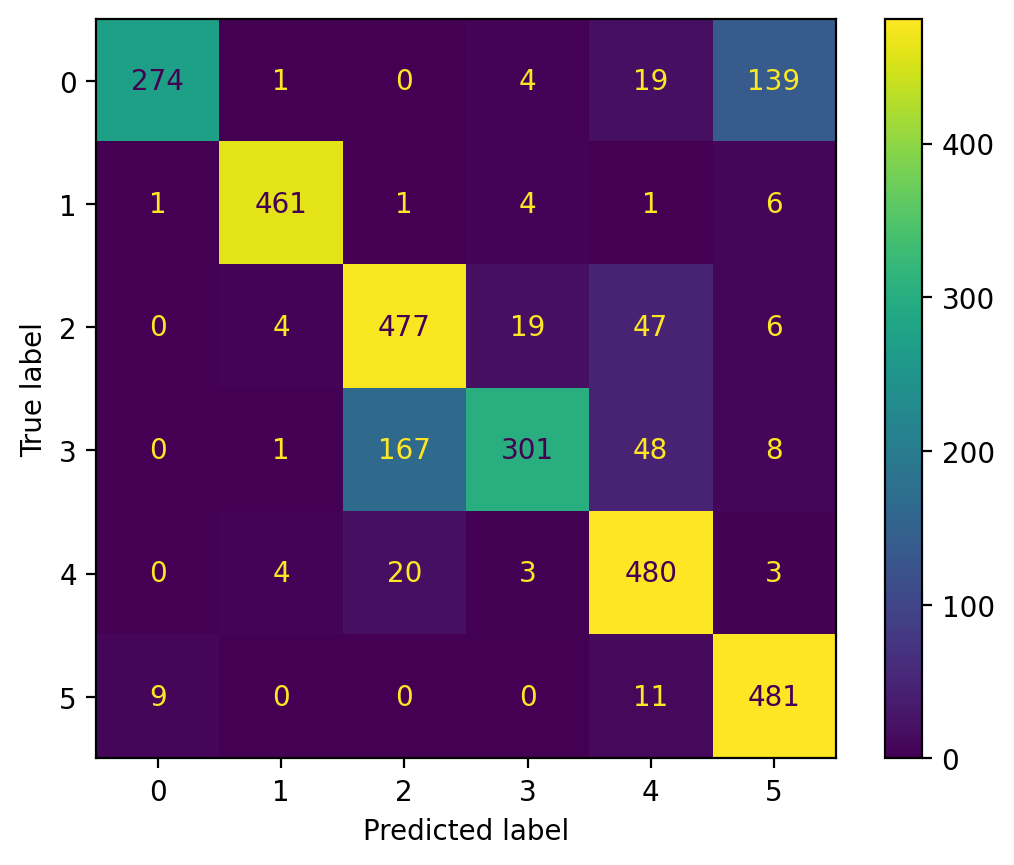

In [ ]:
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = resnet50(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matpririx(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()



# /////////////............../////////////............../////////////..............


from sklearn.metrics import precision_recall_curve
# !pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch

y_pred = []
y_true = []
pred = torch.tensor(y_pred)
true = torch.tensor(y_true)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)



In [ ]:
print(y_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve
# !pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch

y_pred = []
y_true = []
pred = torch.tensor(y_pred)
true = torch.tensor(y_true)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)